In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, BatchNormalization, Conv2DTranspose, Input
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from PIL import Image
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_image_dir = '/content/drive/MyDrive/ISIC-2017_Training_Data/'
train_mask_dir = '/content/drive/MyDrive/ISIC-2017_Training_Part1_GroundTruth/'
val_image_dir = '/content/drive/MyDrive/ISIC-2017_Validation_Data/'
val_mask_dir = '/content/drive/MyDrive/ISIC-2017_Validation_Part1_GroundTruth/'

IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_image_and_mask(image_path, mask_path):
    img = Image.open(image_path.numpy().decode('utf-8'))
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img) / 255.0
    mask = Image.open(mask_path.numpy().decode('utf-8'))
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
    mask = np.array(mask) / 255.0
    return img, mask

def tf_load_image_and_mask(image_path, mask_path):
    img, mask = tf.py_function(load_image_and_mask, [image_path, mask_path], [tf.float32, tf.float32])
    img = tf.reshape(img, [IMG_HEIGHT, IMG_WIDTH, 3])
    mask = tf.reshape(mask, [IMG_HEIGHT, IMG_WIDTH, 1])
    return img, mask

def create_dataset(image_dir, mask_dir):
    image_files = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')])
    mask_files = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(tf_load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1).prefetch(tf.data.AUTOTUNE)
    return dataset

# create training and validation dataset load
train_dataset = create_dataset(train_image_dir, train_mask_dir)
val_dataset = create_dataset(val_image_dir, val_mask_dir)
train_images = []
train_masks = []
for img_batch, mask_batch in train_dataset:
    train_images.append(img_batch.numpy().squeeze())
    train_masks.append(mask_batch.numpy().squeeze())
val_images = []
val_masks = []
for img_batch, mask_batch in val_dataset:
    val_images.append(img_batch.numpy().squeeze())
    val_masks.append(mask_batch.numpy().squeeze())
train_images = np.array(train_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
train_masks = np.array(train_masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
val_images = np.array(val_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
val_masks = np.array(val_masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
train_images = train_images.reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH, 3)
train_masks = train_masks.reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH, 1)
val_images = val_images.reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH, 3)
val_masks = val_masks.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

print(f"train images : {train_images.shape}")
print(f"train masks : {train_masks.shape}")
print(f"validation images : {val_images.shape}")
print(f"validation masks : {val_masks.shape}")


KeyboardInterrupt: 

In [ ]:
# ConvLSTM model
def conv_lstm_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=(1, *input_shape))
    x = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(64, (3, 3), padding="same", return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)
    model = Model(inputs=[inputs], outputs=[x])
    return model

model = conv_lstm_model()

In [ ]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32') # threshold
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy", iou_metric])

image_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

mask_datagen = ImageDataGenerator(rotation_range=15,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

def image_mask_generator(images, masks, batch_size):
    images_reshaped = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    masks_reshaped = masks.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
    image_generator = image_datagen.flow(images_reshaped, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(masks_reshaped, batch_size=batch_size, seed=42)
    while True:
        batch_images = next(image_generator)
        batch_masks = next(mask_generator)
        batch_images = batch_images.reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH, 3)
        yield batch_images, batch_masks

class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, "
              f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

In [ ]:
batch_size = 16

history = model.fit(
    image_mask_generator(train_images, train_masks, batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=(val_images, val_masks),
    epochs=30,
    callbacks=[PrintMetricsCallback()]
)

NameError: name 'train_images' is not defined

In [ ]:
model.save('/content/drive/MyDrive/saved_model/isic_model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/isic_model.h5')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 128, 128, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 1, 128, 128, 64)     │         154,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 128, 128, 64)     │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 1, 128, 128, 64)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 128, 128, 64)     │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 128, 128, 64)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 1)         │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 764,227 (2.92 MB)

 Trainable params: 763,841 (2.91 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
test_image_dir = '/content/drive/MyDrive/ISIC2018_Task3_Test_Input/'
test_mask_dir = '/content/drive/MyDrive/ISIC2018_Task3_Test_Input/'

IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_test_data(image_dir, mask_dir):
    images = []
    masks = []
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_files = sorted(os.listdir(mask_dir))
    for img_file, mask_file in zip(image_files, mask_files):
        img = Image.open(os.path.join(image_dir, img_file)).resize((IMG_WIDTH, IMG_HEIGHT))
        img = np.array(img) / 255.0
        images.append(img)
        mask = Image.open(os.path.join(mask_dir, mask_file)).resize((IMG_WIDTH, IMG_HEIGHT))
        mask = np.array(mask) / 255.0
        masks.append(mask)
    images = np.array(images).reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH, 3)
    masks = np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
    return images, masks

test_images, test_masks = load_test_data(test_image_dir, test_mask_dir)

print(f"Number of test images: {test_images.shape[0]}")


KeyboardInterrupt: 

In [ ]:
test_image_dir = '/content/drive/MyDrive/ISIC_2019_Test_Input/'

IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_test_data(image_dir):
    images = []
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    for img_file in image_files:
        img = Image.open(os.path.join(image_dir, img_file)).resize((IMG_WIDTH, IMG_HEIGHT))
        img = np.array(img) / 255.0
        images.append(img)
    images = np.array(images).reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH, 3)
    return images

test_images = load_test_data(test_image_dir)

print(f"Number of test images: {test_images.shape[0]}")


Number of test images: 3800


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/saved_model/isic_model.h5',
                   custom_objects={'iou_metric': iou_metric})


In [ ]:
test_results = model.evaluate(test_images, test_masks, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test IoU: {test_results[2]:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.8087 - iou_metric: 0.3950 - loss: 0.4180
Test Loss: 0.3335
Test Accuracy: 0.8514
Test IoU: 0.4827


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


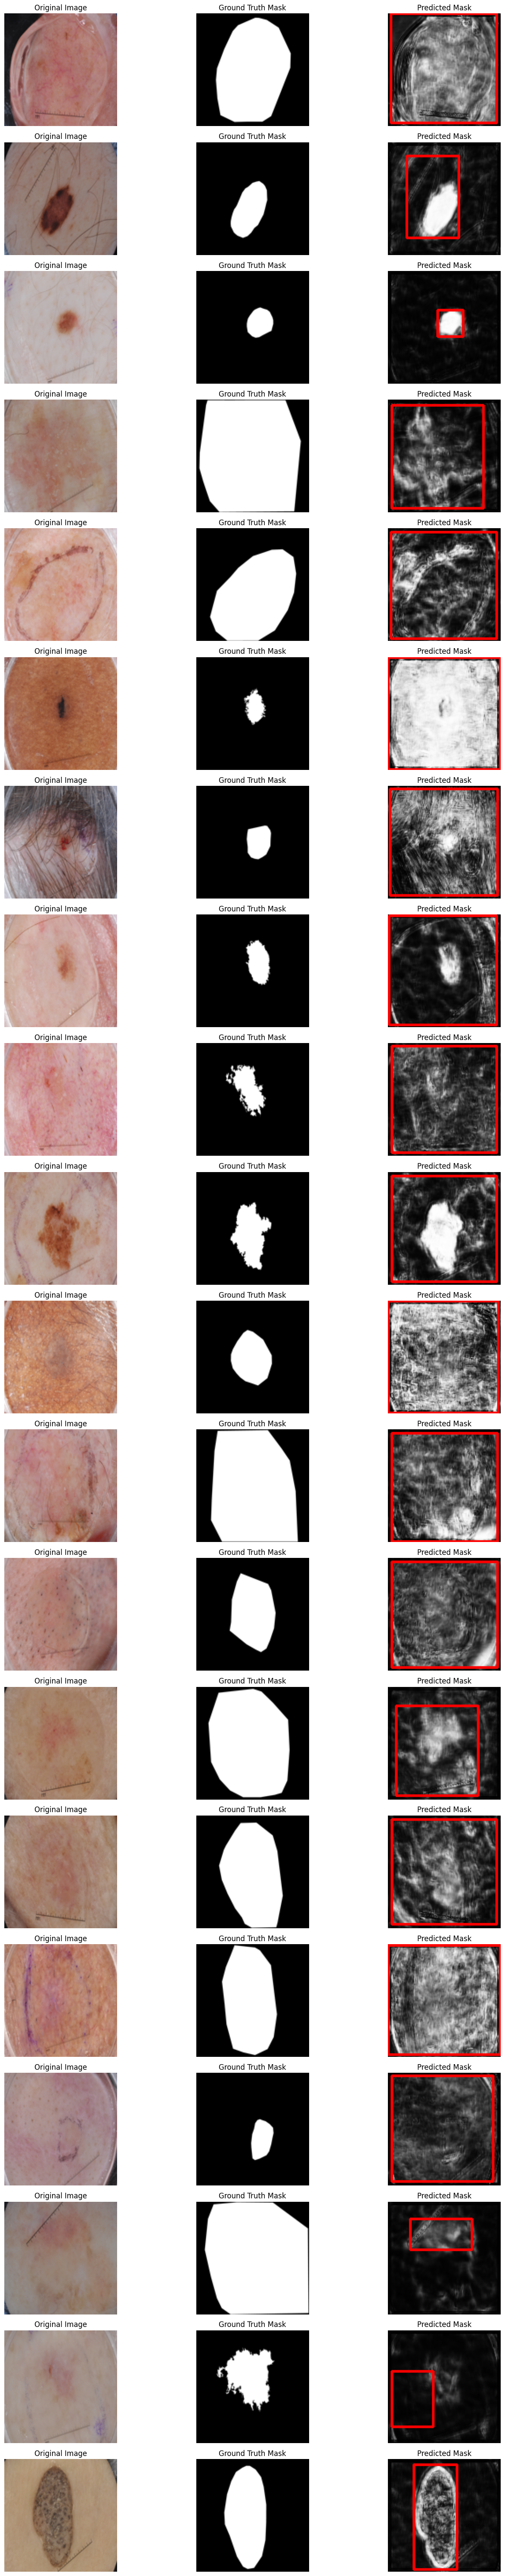

In [ ]:
import cv2

def draw_bounding_box(image, mask, color=(255, 0, 0), thickness=2):
    mask_binary = (mask > 0.5).astype(np.uint8)
    y_indices, x_indices = np.where(mask_binary)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return image
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()
    boxed_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB) if len(image.shape) == 2 else image.copy()
    boxed_image = cv2.rectangle(boxed_image, (min_x, min_y), (max_x, max_y), color, thickness)
    return boxed_image

def display_bounding_boxes(model, images, masks, num_samples=5):
    sample_images = images[:num_samples]
    sample_masks = masks[:num_samples]
    sample_images_no_time = sample_images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    predictions = model.predict(sample_images)
    predictions = predictions.reshape(-1, IMG_HEIGHT, IMG_WIDTH)
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(sample_images_no_time[i])
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(sample_masks[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")
        boxed_prediction = draw_bounding_box(predictions[i], predictions[i])
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(boxed_prediction, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_bounding_boxes(model, test_images, test_masks, num_samples=20)

In [ ]:
import cv2
import os
import numpy as np

def draw_bounding_box(image, mask, color=(255, 0, 0), thickness=2, min_size=10):
    mask_binary = (mask > 0.5).astype(np.uint8)
    y_indices, x_indices = np.where(mask_binary)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None, None
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()
    if (max_x - min_x) < min_size or (max_y - min_y) < min_size:
        return None, None
    bounding_box = (min_x, min_y, max_x, max_y)
    return image, bounding_box

def display_bounding_boxes(model, images, image_files, output_folder="/content/drive/MyDrive/ConvLSTM_Results/2020", min_size=10):
    from google.colab import drive
    drive.mount('/content/drive')

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    sample_images_no_time = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    predictions = model.predict(images)
    predictions = predictions.reshape(-1, IMG_HEIGHT, IMG_WIDTH)
    no_bbox_count = 0
    for i, img_file in enumerate(image_files):
        pred_mask = predictions[i]
        _, bounding_box = draw_bounding_box(pred_mask, pred_mask, min_size=min_size)
        original_image_name = os.path.splitext(img_file)[0]
        if bounding_box is not None:
            x_min, y_min, x_max, y_max = [int(coord) for coord in bounding_box]
            cropped_mask = pred_mask[y_min:y_max, x_min:x_max]
            cropped_mask_path = os.path.join(output_folder, f"{original_image_name}.jpg")
            cv2.imwrite(cropped_mask_path, (cropped_mask * 255).astype(np.uint8))
            bbox_data_path = os.path.join(output_folder, f"{original_image_name}_box_coordinates.txt")
            with open(bbox_data_path, 'w') as f:
                f.write(str(bounding_box))
            print(f"Saved cropped mask: {cropped_mask_path}")
            print(f"Saved bounding box coordinates for: {original_image_name}")
        else:
            no_bbox_count += 1
            print(f"No bounding box found for image: {original_image_name}")

    print(f"Number of images without bounding boxes: {no_bbox_count}")

test_image_dir = '/content/drive/MyDrive/ISIC_2020_Test_Input/'

IMG_HEIGHT = 128
IMG_WIDTH = 128


test_images = test_images.reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH, 3)

print(f"Number of test images: {test_images.shape[0]}")

image_files = sorted([f for f in os.listdir(test_image_dir) if f.endswith('.jpg')])
display_bounding_boxes(model, test_images, image_files, output_folder="/content/drive/MyDrive/ConvLSTM_Results/2020", min_size=10)



Number of test images: 10982


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ISIC_2020_Test_Input/'